# Examine ALOS2 Archive for Name_BOI1EW_232aa-ALOS2.csv
### full catalog search (*no ability to download as of 10/2018)
https://satpf.jp/spf/?sb=search&sensor=ALOS-2_PALSAR-2&item=sb1_sar_palser2

### JAXA search requires old version of firefox that can use Microsoft silverlight (can download csv, kmz, shp)
https://auig2.jaxa.jp/ips/home?language=en_US


In [1]:
import pandas as pd
from pandas.plotting import table
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%matplotlib inline
#%qtconsole
plt.rcParams['font.size'] = 12

In [3]:
# Read everything 
# !! WARNING !! need to add comma at end of first row of heading labels
vectorFile = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_BOI1EW_232aa.shp'
path = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_BOI1EW_232aa-ALOS2.csv'
df = pd.read_csv(path)

In [4]:
# Convenient Summary!
df.groupby(["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"])["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM2             63               870                  FP6-3       1
                                                                       FP6-4       1
                                                                       FP6-5       1
                                                  880                  FP6-3       1
                                                                       FP6-4       1
                                                                       FP6-5       1
                                                                       FP6-6       1
                                 64               860                  FP6-7       1
                                                  870                  FP6-7       1
                 SM3             63               870                  F2-5        8
                                                                       

In [5]:
# # NOTE that only same Operation Mode, OBS Path, Frame, Beam No, can be used for interferometry
# Select count > 2 from this groupby
order = ["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"]
DF = df.groupby(order).filter(lambda x: len(x["Scene ID"]) >= 2)
# Reprint summary as groupby object
DF.groupby(order)["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM3             63               870                  F2-5        8
                                                                       F2-6        6
                                                  880                  F2-5        8
                                                                       F2-6        6
                                 64               860                  F2-6        5
                                                                       F2-7        4
                                                  870                  F2-6        5
                                                                       F2-7        4
                                                  880                  F2-7        5
Descending       SM1             165              2720                 U2-9        2
                                                  2730                 

In [6]:
# NOTE: an alternative to the above!

# Select only paths with more than 10 coincidident acquisitions
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].count().gt(10) #RETURNS GROUP-BY
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].transform("count").gt(10) # RETURNS dataframe index
#DF = df[idx]

In [7]:
def make_footprints(df):
    """ extract shapely polygon footprint"""
    polys = []
    for i,row in df.iterrows():
        uly = row["Scene Upper Left Latitude"]
        ulx = row["Scene Upper Left Longitude"]
        ury = row["Scene Upper Right Latitude"] 
        urx = row["Scene Upper Right Longitude"]
        lly = row["Scene Lower Left Latitude"] 
        llx = row["Scene Lower Left Longitude"] 
        lry = row["Scene Lower Right Latitude"]
        lrx = row["Scene Lower Right Longitude"]
        coords = [ (ulx, uly), (urx, ury), (lrx, lry), (llx, lly), (ulx, uly)]
        polys.append(shapely.geometry.Polygon(np.array(coords).astype('f4')))

    return polys

In [8]:
# Add Polygon footprints
polys = make_footprints(DF)
gf = gpd.GeoDataFrame(DF, geometry=polys, crs={'init': 'epsg:4326'})

# Keep most relevant columns
cols = ["Scene ID", 
        "Operation Mode", 
        "Beam No",
        "OBS Path Number", 
        "Centre Frame Number", 
        "Observation Start Date", 
        "Orbit Direction",
        "Off Nadir Angle",
        "Polarization", 
        "geometry"] 
gf = gf.loc[:, cols]
gf.head()

Scene ID Operation Mode Beam No  OBS Path Number  \
0  ALOS2015332700-140904            WD1      W2              165   
1  ALOS2018510870-140926            SM3    F2-5               63   
2  ALOS2018510880-140926            SM3    F2-5               63   
3  ALOS2019250860-141001            SM3    F2-6               64   
4  ALOS2019250870-141001            SM3    F2-6               64   

   Centre Frame Number Observation Start Date Orbit Direction  \
0                 2700    2014/09/04 12:42:36      Descending   
1                  870    2014/09/26 00:22:58       Ascending   
2                  880    2014/09/26 00:22:58       Ascending   
3                  860    2014/10/01 00:30:12       Ascending   
4                  870    2014/10/01 00:30:12       Ascending   

   Off Nadir Angle Polarization  \
0             34.9        HH+HV   
1             28.2        HH+HV   
2             28.2        HH+HV   
3             32.5        HH+HV   
4             32.5        HH+HV   

                                            geometry  
0  POLYGON ((-115.5670013427734 47.32099914550781...  
1  POLYGON ((-116.0439987182617 44.07799911499023...  
2  POLYGON ((-116.1780014038086 44.57099914550781...  
3  POLYGON ((-116.8239974975586 43.69900131225586...  
4  POLYGON ((-116.9489974975586 44.19300079345703...

In [9]:
# Rename to dinosar conventions
gf.rename(columns={"Observation Start Date" : 'sceneDate', 
                "OBS Path Number" : 'relativeOrbit', 
                "Orbit Direction" : 'flightDirection',
                "Scene ID" : 'sceneId',
                "Operation Mode" : 'opMode',
                "Beam No" : 'beamNo',
                "Centre Frame Number" : 'frame',
                "Off Nadir Angle" : 'incidence',
                "Polarization" : 'polarization'}, 
         inplace=True)
#gf.to_file('query-alos2-dinosar.geojson', driver='GeoJSON')

In [10]:
# Plot these frames on a map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

In [11]:
def plot_map(gf, snwe, vectorFile=None, zoom=8, title='Orbital Footprints', tableFrame=None):
    pad = 1
    S, N, W, E = snwe
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()
    x0, y0 = plot_CRS.transform_point(W-pad, S-pad, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(E+pad, N+pad, geodetic_CRS)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150,
                           subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
    tiler = GoogleTiles(url=url)
    # NOTE: going higher than zoom=8 is slow...
    ax.add_image(tiler, zoom)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linestyle=':')
    ax.coastlines(resolution='10m', color='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS)
    
    if type(tableFrame) == gpd.geodataframe.GeoDataFrame:
        table(ax, tableFrame, loc='top', zorder=10, fontsize=10,
          cellLoc='center', rowLoc='center',
          bbox=[0.1, 0.7, 0.6, 0.3]) 

    # Add region of interest polygon in specified
    if vectorFile:
        tmp = gpd.read_file(vectorFile)
        ax.add_geometries(tmp.geometry.values,
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='m',
                          lw=2,
                          linestyle='dashed')

    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    for orbit, color in zip(orbits, colors):
        df = gf.query('relativeOrbit == @orbit')
        poly = df.geometry.cascaded_union

        if df.flightDirection.iloc[0] == 'ASCENDING':
            linestyle = '--'
            xpos, ypos = poly.centroid.x, poly.bounds[3]
        else:
            linestyle = '-'
            xpos, ypos = poly.centroid.x, poly.bounds[1]

        ax.add_geometries([poly],
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor=color,
                          lw=2,
                          linestyle=linestyle)
        ax.text(xpos, ypos, orbit, color=color, fontsize=16, fontweight='bold',
                transform=geodetic_CRS)

    gl = ax.gridlines(plot_CRS, draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title(title)
    plt.savefig('map.pdf', bbox_inches='tight')

In [12]:
def plot_timeline(gf, title='Acquisition Timeline'):
    """Plot dinosar inventory acquisitions as a timeline.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame

    """

    # Same colors as map
    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    fig, ax = plt.subplots(figsize=(11, 8.5))
    plt.scatter(gf.timeStamp.values, gf.orbitCode.values,
                edgecolors=colors[gf.orbitCode.values], facecolors='None',
                cmap='jet', s=60, label='ALOS-2')

    plt.yticks(gf.orbitCode.unique(), gf.relativeOrbit.unique())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.legend(loc='lower right')
    plt.ylim(-1, orbits.size)
    plt.ylabel('Orbit Number')
    fig.autofmt_xdate()
    plt.title(title)
    plt.savefig('timeline.pdf', bbox_inches='tight')

In [13]:
def print_dates(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['date','dt']]

In [14]:
gf.head()

sceneId opMode beamNo  relativeOrbit  frame  \
0  ALOS2015332700-140904    WD1     W2            165   2700   
1  ALOS2018510870-140926    SM3   F2-5             63    870   
2  ALOS2018510880-140926    SM3   F2-5             63    880   
3  ALOS2019250860-141001    SM3   F2-6             64    860   
4  ALOS2019250870-141001    SM3   F2-6             64    870   

             sceneDate flightDirection  incidence polarization  \
0  2014/09/04 12:42:36      Descending       34.9        HH+HV   
1  2014/09/26 00:22:58       Ascending       28.2        HH+HV   
2  2014/09/26 00:22:58       Ascending       28.2        HH+HV   
3  2014/10/01 00:30:12       Ascending       32.5        HH+HV   
4  2014/10/01 00:30:12       Ascending       32.5        HH+HV   

                                            geometry  
0  POLYGON ((-115.5670013427734 47.32099914550781...  
1  POLYGON ((-116.0439987182617 44.07799911499023...  
2  POLYGON ((-116.1780014038086 44.57099914550781...  
3  POLYGON ((-116.8239974975586 43.69900131225586...  
4  POLYGON ((-116.9489974975586 44.19300079345703...

In [15]:
# Generate plots for all possible interferometric pairs (with dinosar naming scheme)
order = ["flightDirection", "opMode", "relativeOrbit", "frame", "beamNo"]
GF = gf.groupby(order).filter(lambda x: len(x["sceneId"]) > 2)
# Reprint summary as groupby object

w, s, e, n = GF.geometry.cascaded_union.bounds
snwe = [s, n, w, e]

GF.groupby(order)["sceneId"].count()

flightDirection  opMode  relativeOrbit  frame  beamNo
Ascending        SM3     63             870    F2-5       8
                                               F2-6       6
                                        880    F2-5       8
                                               F2-6       6
                         64             860    F2-6       5
                                               F2-7       4
                                        870    F2-6       5
                                               F2-7       4
                                        880    F2-7       5
Descending       WD1     165            2700   W2        26
                         167            2750   W2        29
Name: sceneId, dtype: int64

In [16]:
GB = GF.groupby(order)["sceneId"]
print(GB.groups)

{('Ascending', 'SM3', 63, 870, 'F2-5'): Int64Index([1, 18, 28, 50, 88, 99, 119, 126], dtype='int64'), ('Ascending', 'SM3', 63, 870, 'F2-6'): Int64Index([5, 32, 54, 84, 106, 123], dtype='int64'), ('Ascending', 'SM3', 63, 880, 'F2-5'): Int64Index([2, 19, 29, 51, 89, 100, 120, 127], dtype='int64'), ('Ascending', 'SM3', 63, 880, 'F2-6'): Int64Index([6, 33, 55, 85, 107, 124], dtype='int64'), ('Ascending', 'SM3', 64, 860, 'F2-6'): Int64Index([3, 30, 52, 115, 121], dtype='int64'), ('Ascending', 'SM3', 64, 860, 'F2-7'): Int64Index([13, 56, 94, 130], dtype='int64'), ('Ascending', 'SM3', 64, 870, 'F2-6'): Int64Index([4, 31, 53, 116, 122], dtype='int64'), ('Ascending', 'SM3', 64, 870, 'F2-7'): Int64Index([14, 57, 95, 131], dtype='int64'), ('Ascending', 'SM3', 64, 880, 'F2-7'): Int64Index([15, 48, 58, 96, 132], dtype='int64'), ('Descending', 'WD1', 165, 2700, 'W2'): Int64Index([  0,   7,   9,  11,  20,  22,  23,  34,  36,  38,  40,  41,  43,
             45,  59,  64,  70,  71,  73,  82,  83,  87,

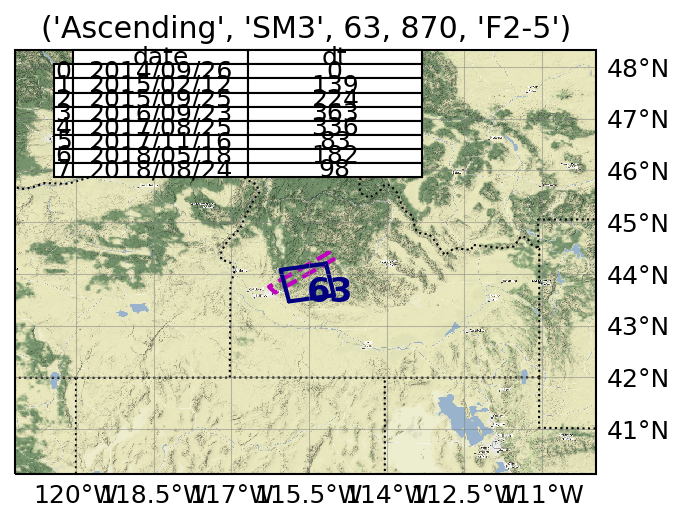

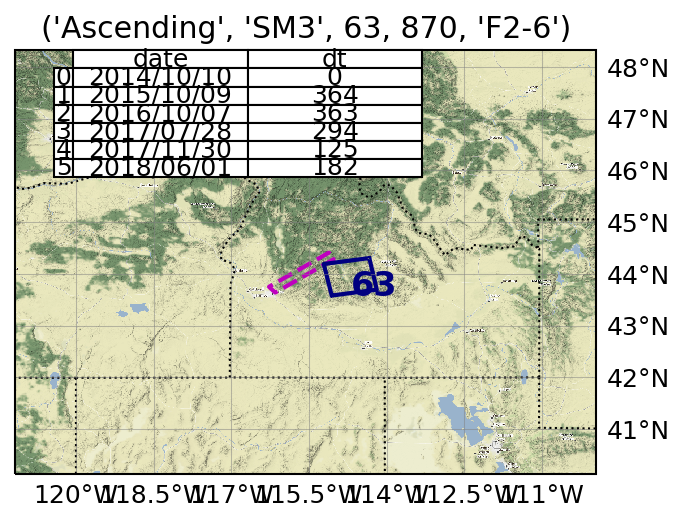

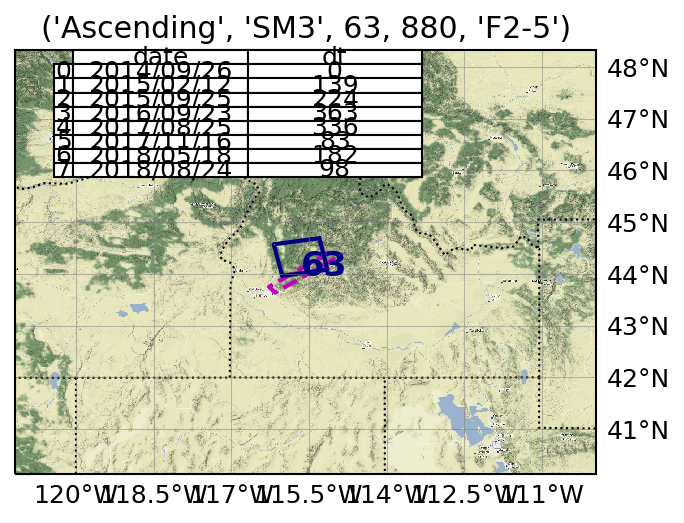

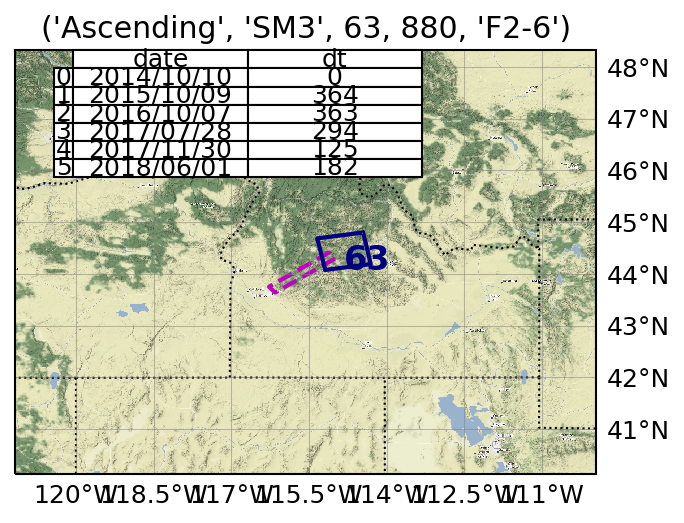

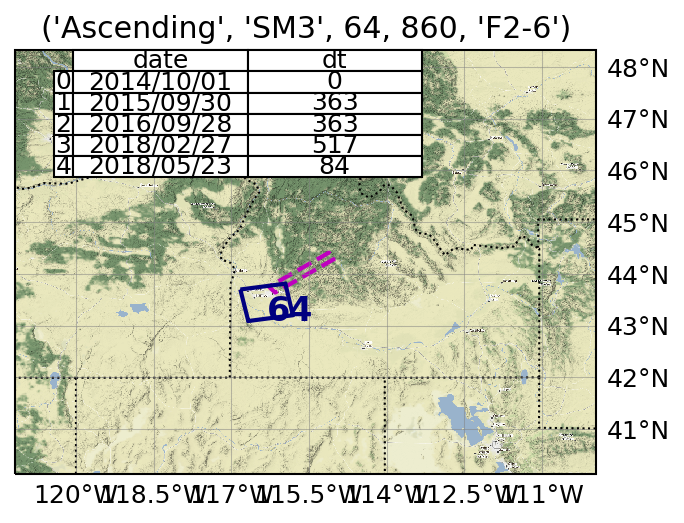

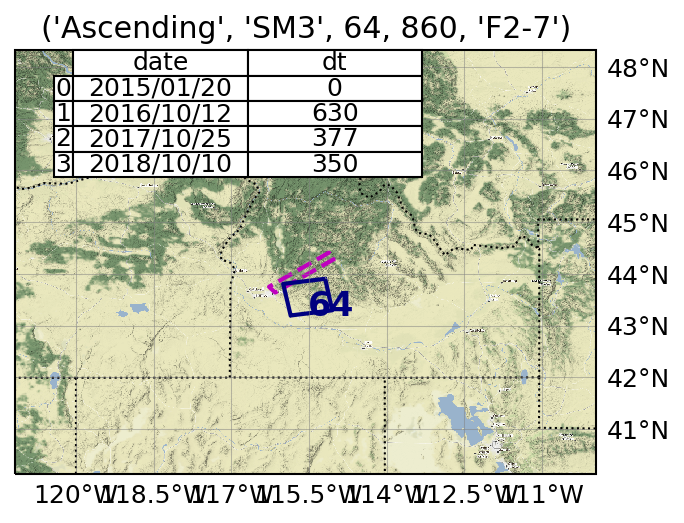

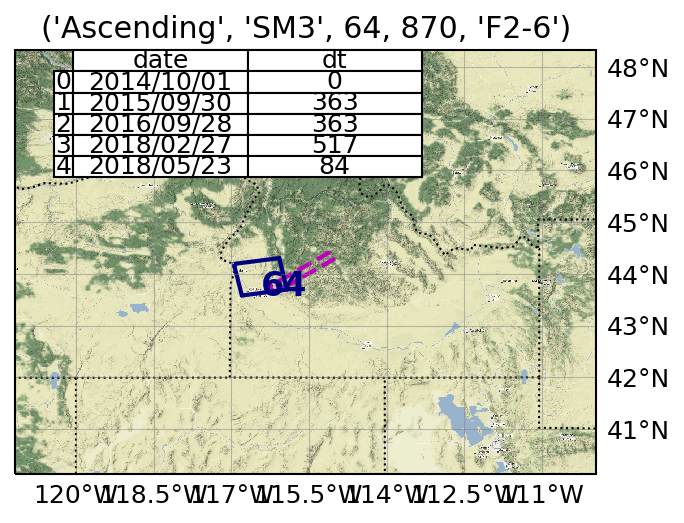

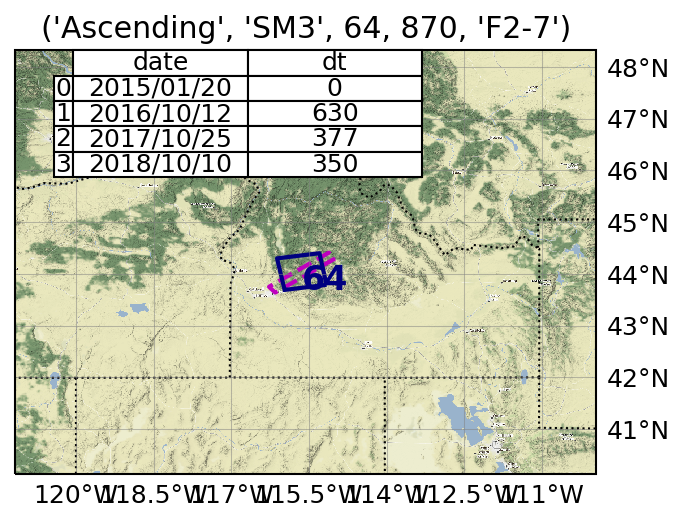

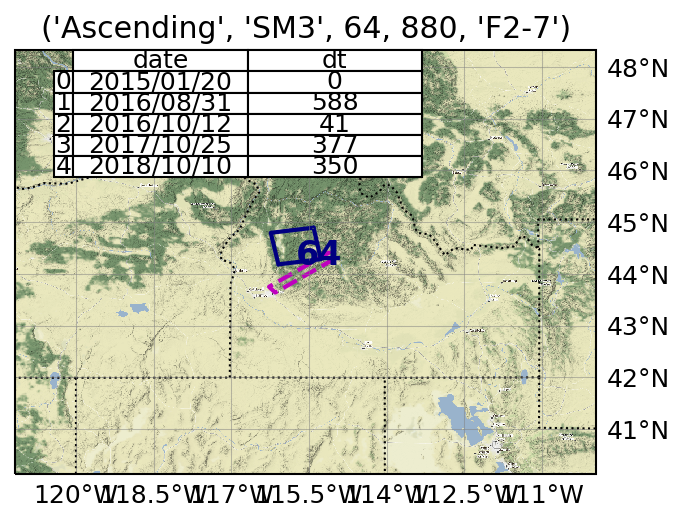

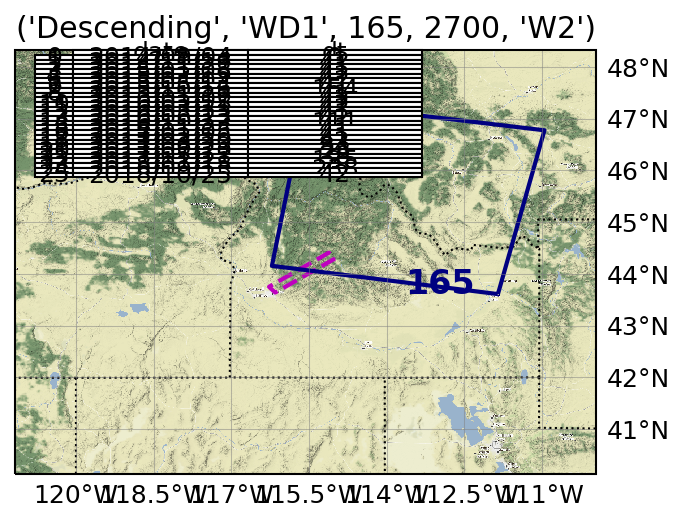

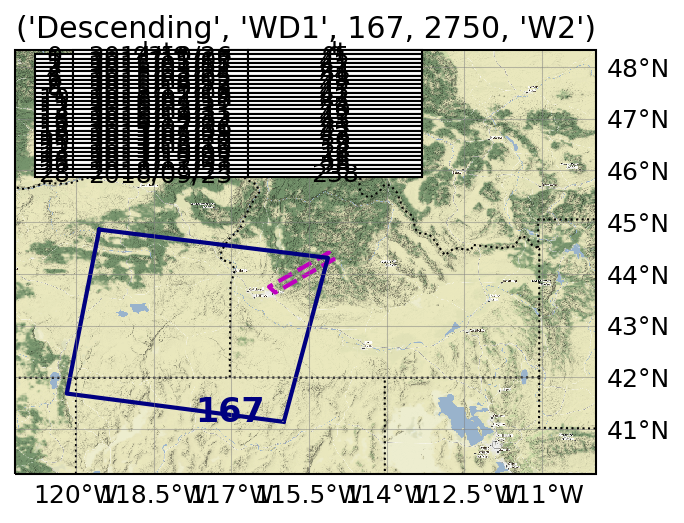

In [17]:
# Print maps for all combinations of possible interferometric pairs!
for labels, indices in GB.groups.items():
    #print(labels, indices)
    #print(labels, DF.loc[indices, "Scene ID"].tolist())
    inventory = GF.loc[indices]
    tmp = print_dates(inventory)
    plot_map(inventory, snwe, vectorFile, title=str(labels), tableFrame=tmp)

In [21]:
def print_inventory(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['sceneId','date','dt']]

In [22]:
print_inventory(inventory)

sceneId        date   dt
0   ALOS2023022750-141026  2014/10/26    0
1   ALOS2029232750-141207  2014/12/07   41
2   ALOS2035442750-150118  2015/01/18   42
3   ALOS2041652750-150301  2015/03/01   41
4   ALOS2054072750-150524  2015/05/24   84
5   ALOS2060282750-150705  2015/07/05   41
6   ALOS2064422750-150802  2015/08/02   28
7   ALOS2070632750-150913  2015/09/13   42
8   ALOS2076842750-151025  2015/10/25   42
9   ALOS2083052750-151206  2015/12/06   41
10  ALOS2089262750-160117  2016/01/17   42
11  ALOS2101682750-160410  2016/04/10   84
12  ALOS2107892750-160522  2016/05/22   42
13  ALOS2118242750-160731  2016/07/31   70
14  ALOS2124452750-160911  2016/09/11   42
15  ALOS2130662750-161023  2016/10/23   42
16  ALOS2136872750-161204  2016/12/04   41
17  ALOS2149292750-170226  2017/02/26   83
18  ALOS2155502750-170409  2017/04/09   42
19  ALOS2161712750-170521  2017/05/21   42
20  ALOS2172062750-170730  2017/07/30   70
21  ALOS2176202750-170827  2017/08/27   28
22  ALOS2178272750-170910  2017/09/10   14
23  ALOS2182412750-171008  2017/10/08   28
24  ALOS2184482750-171022  2017/10/22   14
25  ALOS2190692750-171203  2017/12/03   41
26  ALOS2194832750-171231  2017/12/31   28
27  ALOS2198972750-180128  2018/01/28   28
28  ALOS2234162750-180923  2018/09/23  238

In [23]:
inventory

sceneId opMode beamNo  relativeOrbit  frame  \
8    ALOS2023022750-141026    WD1     W2            167   2750   
10   ALOS2029232750-141207    WD1     W2            167   2750   
12   ALOS2035442750-150118    WD1     W2            167   2750   
21   ALOS2041652750-150301    WD1     W2            167   2750   
24   ALOS2054072750-150524    WD1     W2            167   2750   
25   ALOS2060282750-150705    WD1     W2            167   2750   
26   ALOS2064422750-150802    WD1     W2            167   2750   
27   ALOS2070632750-150913    WD1     W2            167   2750   
35   ALOS2076842750-151025    WD1     W2            167   2750   
37   ALOS2083052750-151206    WD1     W2            167   2750   
39   ALOS2089262750-160117    WD1     W2            167   2750   
42   ALOS2101682750-160410    WD1     W2            167   2750   
44   ALOS2107892750-160522    WD1     W2            167   2750   
46   ALOS2118242750-160731    WD1     W2            167   2750   
49   ALOS2124452750-160911    WD1     W2            167   2750   
60   ALOS2130662750-161023    WD1     W2            167   2750   
65   ALOS2136872750-161204    WD1     W2            167   2750   
72   ALOS2149292750-170226    WD1     W2            167   2750   
74   ALOS2155502750-170409    WD1     W2            167   2750   
79   ALOS2161712750-170521    WD1     W2            167   2750   
86   ALOS2172062750-170730    WD1     W2            167   2750   
90   ALOS2176202750-170827    WD1     W2            167   2750   
91   ALOS2178272750-170910    WD1     W2            167   2750   
92   ALOS2182412750-171008    WD1     W2            167   2750   
93   ALOS2184482750-171022    WD1     W2            167   2750   
108  ALOS2190692750-171203    WD1     W2            167   2750   
112  ALOS2194832750-171231    WD1     W2            167   2750   
114  ALOS2198972750-180128    WD1     W2            167   2750   
129  ALOS2234162750-180923    WD1     W2            167   2750   

               sceneDate flightDirection  incidence polarization  \
8    2014/10/26 12:57:12      Descending       34.9        HH+HV   
10   2014/12/07 11:57:12      Descending       34.9        HH+HV   
12   2015/01/18 11:57:12      Descending       34.9        HH+HV   
21   2015/03/01 11:57:11      Descending       34.9        HH+HV   
24   2015/05/24 12:57:08      Descending       34.9        HH+HV   
25   2015/07/05 12:57:07      Descending       34.9        HH+HV   
26   2015/08/02 12:57:07      Descending       34.9        HH+HV   
27   2015/09/13 12:57:07      Descending       34.9        HH+HV   
35   2015/10/25 12:57:07      Descending       34.9        HH+HV   
37   2015/12/06 11:57:08      Descending       34.9        HH+HV   
39   2016/01/17 11:57:08      Descending       34.9        HH+HV   
42   2016/04/10 12:57:04      Descending       34.9        HH+HV   
44   2016/05/22 12:57:04      Descending       34.9        HH+HV   
46   2016/07/31 12:57:04      Descending       34.9        HH+HV   
49   2016/09/11 12:57:04      Descending       34.9        HH+HV   
60   2016/10/23 12:57:04      Descending       34.9        HH+HV   
65   2016/12/04 11:57:05      Descending       34.9        HH+HV   
72   2017/02/26 11:57:02      Descending       34.9        HH+HV   
74   2017/04/09 12:57:00      Descending       34.9        HH+HV   
79   2017/05/21 12:57:00      Descending       34.9        HH+HV   
86   2017/07/30 12:57:00      Descending       34.9        HH+HV   
90   2017/08/27 12:57:00      Descending       34.9           HH   
91   2017/09/10 12:57:01      Descending       34.9        HH+HV   
92   2017/10/08 12:57:01      Descending       34.9           HH   
93   2017/10/22 12:57:02      Descending       34.9        HH+HV   
108  2017/12/03 11:57:03      Descending       34.9        HH+HV   
112  2017/12/31 11:57:03      Descending       34.9           HH   
114  2018/01/28 11:57:03      Descending       34.9           HH   
129  2018/09/23 12:57:02      Descending       34.9           HH  